In [428]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from linear_regression import LinearRegression
import gurobipy as gp
from gurobipy import GRB
import algorithms
import postprocessing

### Load in Data.

In [495]:
# read in the ct data.
bird_data = pd.read_csv('data/bird.csv')
bird_data

,wingcrd,flatwing,tarsus,head,culmen,nalospi,wt,bandstat,initials,Year,Month,Day,Location,SpeciesCode,Sex,Age
0,59.0,60.0,22.3,31.2,12.3,13.0,9.5,1,2,2002,9,19,4,1,0,2
1,54.0,55.0,20.3,28.3,10.8,7.8,12.2,1,2,2002,10,4,4,3,0,2
2,53.0,54.0,21.6,30.2,12.5,8.5,13.8,1,2,2002,10,4,4,3,0,2
3,55.0,56.0,19.7,30.4,12.1,8.3,13.8,1,8,2002,7,30,9,1,0,2
4,55.0,56.0,20.3,28.7,11.2,8.0,14.1,1,3,2002,10,4,4,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,61.0,62.0,23.4,35.2,15.5,10.8,25.5,1,4,2003,6,7,7,2,5,1
1291,64.5,65.0,22.9,35.1,14.8,11.6,25.8,1,6,2003,6,6,11,2,4,1
1292,63.0,64.0,23.2,35.0,14.9,12.7,26.1,1,3,2002,6,25,9,2,4,1
1293,63.0,64.0,24.4,35.7,16.5,12.0,26.5,1,4,2003,6,7,7,2,4,1


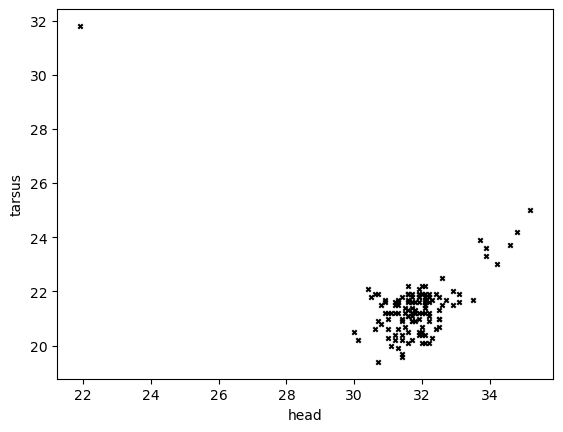

In [496]:
# thin the data set so that 1 data point is ~1%.
np.random.seed(4) # we choose a seed so that the data maintains the outlier point.
bird_thinned = bird_data.sample(frac=0.1).reset_index(drop=True)
bird_thinned

plt.scatter(bird_thinned['head'], bird_thinned['tarsus'], s=10, c='black', marker='x')
plt.xlabel('head')
plt.ylabel('tarsus')
plt.show()

In [498]:
# find the index of the datapoint that has tarsus > 30.
# this is the outlier.
outlier_index = bird_thinned[bird_thinned['head'] < 22].index
outlier_index

Index([0], dtype='int64')

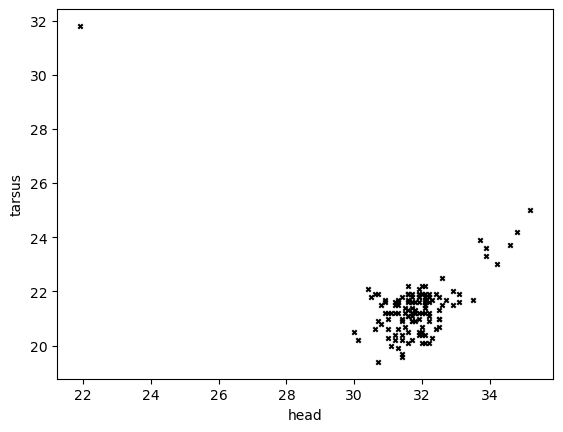

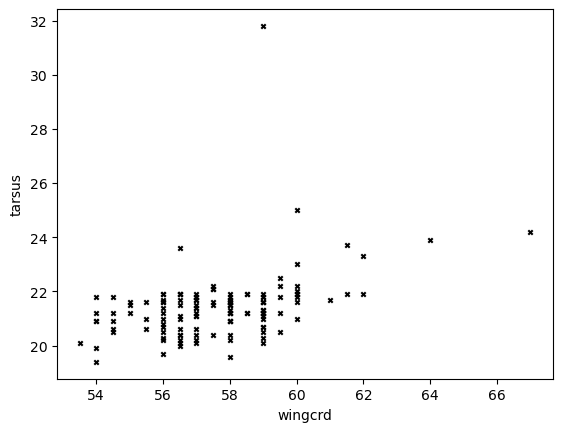

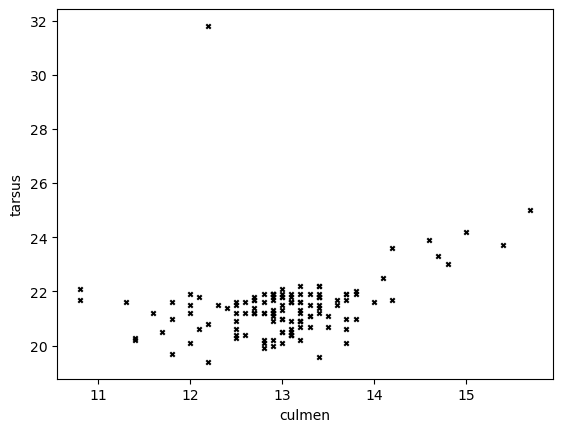

In [ ]:
# create a scatter plot of head vs. each feature.
plt.scatter(bird_thinned['head'], bird_thinned['tarsus'], s=10, c='black', marker='x')
plt.xlabel('head')
plt.ylabel('tarsus')
plt.show()

plt.scatter(bird_thinned['wingcrd'], bird_thinned['tarsus'], s=10, c='black', marker='x')
plt.xlabel('wingcrd')
plt.ylabel('tarsus')
plt.show()

plt.scatter(bird_thinned['culmen'], bird_thinned['tarsus'], s=10, c='black', marker='x')
plt.xlabel('culmen')
plt.ylabel('tarsus')
plt.show()

In [500]:
# select data points that have head > 24.
bird_modified = bird_thinned.drop(outlier_index)
bird_modified

,wingcrd,flatwing,tarsus,head,culmen,nalospi,wt,bandstat,initials,Year,Month,Day,Location,SpeciesCode,Sex,Age
1,56.5,57.5,21.9,30.7,12.0,8.5,17.0,1,3,2004,8,11,6,1,0,2
2,56.0,57.5,21.0,31.0,13.0,9.2,19.2,1,8,2002,6,26,7,1,5,1
3,56.5,58.0,20.4,31.4,13.1,9.0,17.5,1,4,2003,6,6,11,1,4,1
4,60.0,61.0,22.2,32.0,13.4,9.3,20.0,1,2,2003,6,6,11,1,4,1
5,58.0,59.0,20.9,31.7,12.9,8.6,19.8,1,2,2002,6,2,5,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,57.0,58.0,21.1,31.6,12.9,10.2,18.0,1,3,2003,7,8,11,1,4,1
126,58.0,58.5,21.6,31.2,11.3,7.9,18.2,1,6,2003,7,26,11,1,0,2
127,56.0,57.0,21.6,32.1,12.8,9.1,19.8,1,2,2003,7,9,8,1,4,1
128,56.0,57.0,20.2,31.4,12.8,8.8,17.9,1,4,2003,6,20,8,1,4,1


In [ ]:
xc1 = bird_thinned['head'].to_numpy()
xc2 = bird_thinned['wingcrd'].to_numpy()
xc3 = bird_thinned['culmen'].to_numpy()
xc4 = bird_thinned['flatwing'].to_numpy()
xc5 = bird_thinned['nalospi'].to_numpy()
mat = np.vstack([xc1, xc2, xc3])
mat_final = mat.T
y = bird_thinned['tarsus'].to_numpy()

# Add an intercept term.
df = pd.DataFrame(mat_final)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr

# fit a linear regression on full data.
xc1_mod = bird_modified['head'].to_numpy()
xc2_mod = bird_modified['wingcrd'].to_numpy()
xc3_mod = bird_modified['culmen'].to_numpy()
xc4_mod = bird_modified['flatwing'].to_numpy()
xc5_mod = bird_modified['nalospi'].to_numpy()
mat_mod = np.vstack([xc1_mod, xc2_mod, xc3_mod])
mat_final_mod = mat_mod.T
y_mod = bird_modified['tarsus'].to_numpy()

# Add an intercept term.
df_mod = pd.DataFrame(mat_final_mod)
df_mod.insert(0, 'Ones', 1)
arr_mod = df_mod.values
x_mod = arr_mod

In [504]:
# fit the model
lr = LinearRegression(x=x.T, y=y)
lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
) 

Estimated beta1 with full dataset: -0.6927993326986843


In [505]:
# fit the model
modified_lr = LinearRegression(x=x_mod.T, y=y_mod)
modified_lr.fit()
print(
    f"Estimated beta1 with modified dataset: {modified_lr.beta[1]}"
)

Estimated beta1 with modified dataset: 0.3989748041044802


#### Plot the data

In [506]:
# retrieve the outlier x value.
mis_df = bird_thinned.iloc[[0]]
mis_x = mis_df['head']
mis_y = mis_df['tarsus']

# retrieve all other x values.
not_mis_df = bird_thinned.drop(0)

not_mis_x = not_mis_df['head'].to_numpy()
not_mis_y = not_mis_df['tarsus'].to_numpy()

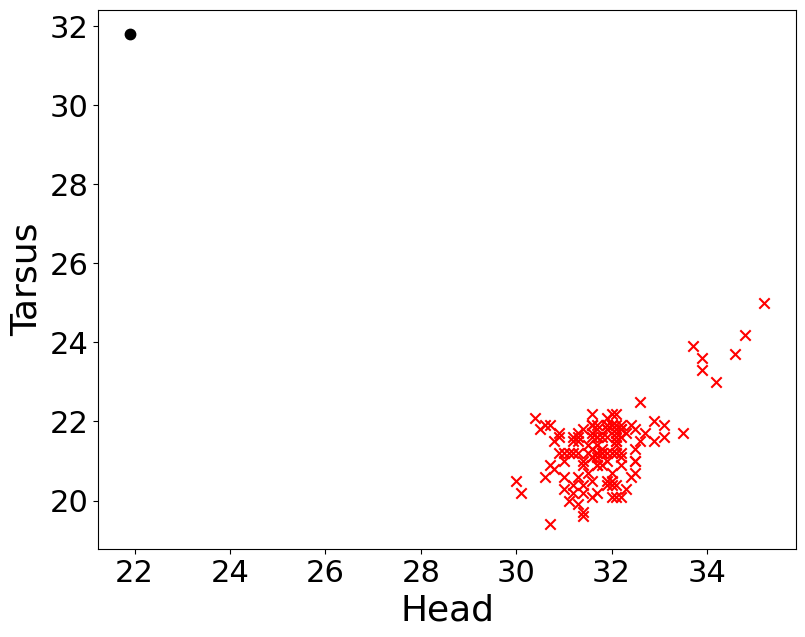

In [ ]:
### create scatter plot.
plt.figure(figsize=(9, 7))

plt.scatter(not_mis_x, not_mis_y, marker='x', color='r', s=56)
plt.scatter(mis_x, mis_y, marker='o', color='black', s=56)

# x_values = np.linspace(15, 35, 100)
# y_values_full = lr.beta[1] * x_values + lr.beta[2] * x_values + lr.beta[3] * x_values + lr.beta[0]
# y_value_red_crosses = modified_lr.beta[1] * x_values + modified_lr.beta[2] * x_values + modified_lr.beta[3] * x_values + modified_lr.beta[0]
# plt.plot(x_values, y_values_full, color='black', linestyle='--') 
# plt.plot(x_values, y_value_red_crosses, color='black')

plt.xlabel('Head', fontsize=26)
plt.ylabel('Tarsus', fontsize=26)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)
# plt.savefig('birds_scatter.pdf')
plt.show()

## Run Data-dropping Approximations

### Net Approx. Algorithm

In [463]:
Xnet = np.hstack([x[:, 1:], x[:, [0]]])

In [464]:
trials = 1000
n_sumwstar, wstar = algorithms.net_algorithm(Xnet,y,1000)
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indices of the MIS.
alphaN = 1
mis_inds = np.argsort(wstar)[:alphaN]
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 11.91026184415152


array([33])

In [466]:
inds = mis_inds
new_x= np.delete(x, inds, axis=0)
new_y= np.delete(y, inds, axis=0)
print(new_x.shape)
print(new_y.shape)

lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset: {modified_lr_na.beta[1]}"
)

(129, 4)
(129,)
Estimated beta1 with full dataset: -0.6927993326986843
Estimated beta1 after removing subset: -0.7194194077140659


NetApprox fails on the bird dataset, choosing the incorrect index.

### FH-Gurobi (warm-start)

In [467]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 260 rows, 134 columns and 260 nonzeros
Model fingerprint: 0xd61a9588
Model has 5 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 4e+03]
  QLMatrix range   [2e+01, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 260 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 260 rows and 0 columns
Presolve time: 0.00s
Presolved: 2084 rows, 655 columns, 6760 nonzeros
Presolved model has 520 bilinear constraint(

In [468]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 135 columns and 1 nonzeros
Model fingerprint: 0x507f53f9
Model has 5 quadratic constraints
Variable types: 5 continuous, 130 integer (130 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 4e+03]
  QLMatrix range   [2e+01, 2e+03]
  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

User MIP start produced solution with objective 126 (0.01s)
Loaded user MIP start with objective 126

Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 1304 rows, 2085 columns, 6370 nonzeros
Presolved model has 1300 SOS constraint(s)
Found heuristic solution: objective 126.0000000
Variable types: 1305 continuous, 780 integer (780 binary)

Root relaxation: objective 1.300000e+02, 263 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  130.00000    0    4  126.00000  130.00000  3.17%     -    0s
     0     0  130.00000    0    4  126.00000  130.00000  3.17%     -    0s
     0     2  130.00000    0    4  126.00000  130.00000  3.17%     -    0s
 15921  1792  128.00000  104    4  126.00000  129.00000  2.38%   103    5s
 35935  3990  128.00000  126  

In [469]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove, len(indices_to_remove)

(array([ 0,  7, 34, 92]), 4)

#### Refit after Removing Flagged Points.

In [470]:
inds = indices_to_remove
new_x= np.delete(x, inds, axis=0)
new_y= np.delete(y, inds, axis=0)
print(new_x.shape)
print(new_y.shape)

lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset: {modified_lr_na.beta[1]}"
)

(126, 4)
(126,)
Estimated beta1 with full dataset: -0.6927993326986843
Estimated beta1 after removing subset: 0.5539224832490446


### FH-Gurobi (no warm start)

In [471]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 135 columns and 1 nonzeros
Model fingerprint: 0xd898c349
Model has 5 quadratic constraints
Variable types: 5 continuous, 130 integer (130 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 4e+03]
  QLMatrix range   [2e+01, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 1304 rows, 2085 columns, 6370 nonzeros
Presolved model has 1300 SOS constraint(s)
Variable types: 1305 continuous, 780 integer (780 binary)



Root relaxation: objective 1.300000e+02, 263 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  130.00000    0    4   -0.00000  130.00000      -     -    0s
     0     0  130.00000    0    4   -0.00000  130.00000      -     -    0s
     0     2  130.00000    0    4   -0.00000  130.00000      -     -    0s
H   30    68                       2.0000000  130.00000  6400%   1.8    0s
H  198   208                       3.0000000  130.00000  4233%   2.2    0s
H 1318  1326                       4.0000000  130.00000  3150%   2.5    0s
H 1865  1874                       5.0000000  130.00000  2500%   2.5    0s
H 5470  4326                      18.0000000  130.00000   622%   6.2    1s
H 6638  4668                      37.0000000  130.00000   251%   8.1    1s
 30386 19749   92.00000  140    3   37.00000  129.00000   249%  13.7    5s
 71782 48

In [472]:
weights_array = np.array([w.X for w in weights])

In [473]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(weights_array == 0)[0]
indices_to_remove

array([ 0, 27, 33, 34])

In [474]:
inds = indices_to_remove
new_x= np.delete(x, inds, axis=0)
new_y= np.delete(y, inds, axis=0)
print(new_x.shape)
print(new_y.shape)

lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset: {modified_lr_na.beta[1]}"
)

(126, 4)
(126,)
Estimated beta1 with full dataset: -0.6927993326986843
Estimated beta1 after removing subset: 0.4102769407292618


#### Refit after Removing Flagged Points.

In [419]:
Gurobi_inds= indices_to_remove
new_x= np.delete(x, Gurobi_inds, axis=0)
new_y= np.delete(y, Gurobi_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(104, 4)
(104,)


In [336]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by gurobi: {modified_lr_na.beta[1]}"
)

Estimated beta1 with full dataset: -0.6650544481562014
Estimated beta1 after removing subset specified by gurobi: 0.42043194546371876


### Additive algorithms.

In [475]:
scores_df = postprocessing.compute_scores(x, y, lr, False)
scores_df

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1.0,31.8,3.851940,0.732227,0.292347,1.091774,0,0,0.292347,1.091774
1,1.0,21.9,0.838382,0.020816,0.001038,0.001060,90,90,0.004978,0.005059
2,1.0,21.0,-0.572324,0.017204,-0.003175,-0.003230,27,27,0.003592,0.003708
3,1.0,20.4,-1.103733,0.012457,-0.003579,-0.003624,83,83,0.002824,0.002870
4,1.0,22.2,-0.010640,0.018538,-0.000024,-0.000025,112,112,0.002553,0.002628
...,...,...,...,...,...,...,...,...,...,...
125,1.0,21.1,-0.220864,0.008398,-0.000103,-0.000104,101,101,-0.015531,-0.015759
126,1.0,21.6,1.101990,0.063109,-0.007689,-0.008206,103,103,-0.016253,-0.016713
127,1.0,21.6,0.958315,0.015304,-0.004648,-0.004720,75,75,-0.022971,-0.025401
128,1.0,20.2,-0.926645,0.012520,-0.000808,-0.000818,33,33,-0.023659,-0.026620


In [476]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(scores_df["sorted_IF_scores"][:1]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is {round(lr.beta[1] + sum(scores_df["sorted_1Exact_scores"][:1]), 4)}.')

The AMIP approximation of the refit is -0.4005.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is 0.399.


In [477]:
#### Refit after Removing Flagged Points.
new_x= np.delete(x, scores_df["sorted_IF_indices"][:1], axis=0)
new_y= np.delete(y, scores_df["sorted_IF_indices"][:1], axis=0)
print(new_x.shape)
print(new_y.shape)

new_x_1exact= np.delete(x, scores_df["sorted_1Exact_indices"][:1], axis=0)
new_y_1exact= np.delete(y, scores_df["sorted_1Exact_indices"][:1], axis=0)
print(new_x_1exact.shape)
print(new_y_1exact.shape)

(129, 4)
(129,)
(129, 4)
(129,)


In [478]:
modified_lr_amip = LinearRegression(x=new_x.T, y=new_y)
modified_lr_amip.fit()
print(
    f"Estimated beta1 after removing subset specified by AMIP: {modified_lr_amip.beta[1]}"
)
modified_lr_1exact = LinearRegression(x=new_x_1exact.T, y=new_y_1exact)
modified_lr_1exact.fit()
print(
    f"Estimated beta1 after removing subset specified by 1Exact: {modified_lr_1exact.beta[1]}"
)

Estimated beta1 after removing subset specified by AMIP: 0.3989748041044802
Estimated beta1 after removing subset specified by 1Exact: 0.3989748041044802


### Greedy Algorithms.

In [490]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = postprocessing.create_orig_df(orig_x, orig_y, lr, False)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)[::-1]
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)[::-1]
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

inds [  0  90  27  83 112  45  13   7  65 107]
newton_inds [  0  90  27  83 112  45  13   7  65 107]


In [491]:
import importlib
import linear_regression
importlib.reload(linear_regression)
import algorithms
importlib.reload(algorithms)
import postprocessing
importlib.reload(postprocessing)

<module 'postprocessing' from '/Users/JennyH/Desktop/if-image-text/image-text/gradientBasedDataDroppingFailureModes/postprocessing.py'>

In [ ]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = algorithms.Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, False, method='IF')

print("dropped order: \n", dropped_order[:3])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:3])